In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
from toolz import merge

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as ticker

import pandas as pd
import seaborn as sns
import numpy as np

import scipy
import scipy.interpolate

from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.linear_model import Ridge

from sbibm.utils.io import get_tensor_from_csv

from notebook import figsize

In [3]:
columns = ['task', 'num_observation', 'algorithm', 'num_atoms', 'gamma', 'num_blocks']

def select_architechture_and_algorithm(df: pd.DataFrame) -> pd.DataFrame:
    return df[(df["algorithm"] == "CNRE") & (df["num_blocks"] == 3) & (df["task"] == "slcp")]

## load

In [4]:
# load
files = [
    "fix-bench.csv", 
]
df = pd.concat([pd.read_csv(file, index_col=0) for file in files], ignore_index=True)

# melt rows and add the c2st column
df = pd.wide_to_long(
    df, 
    ["C2ST_Z"], 
    i=["task", "algorithm", "num_atoms", "gamma", "num_blocks", "hidden_features", "seed"], 
    j="num_observation", 
    sep="-"
)

## setup to interpolate

In [5]:
# compute mean and std
df_agg = df.groupby([
    "task",
    "algorithm",
    "num_contrastive_parameters",
    "gamma",
    "num_blocks",
]).aggregate({
    "C2ST_Z": ["mean", "std"],
})

# format
df_agg = df_agg.reset_index()
df_agg = select_architechture_and_algorithm(df_agg)
flat_columns = [" ".join([i, j]).strip() for i, j in df_agg.columns.to_flat_index().tolist()]
df_agg.columns = flat_columns
df_agg

,task,algorithm,num_contrastive_parameters,gamma,num_blocks,C2ST_Z mean,C2ST_Z std
97,slcp,CNRE,2,0.001,3,0.845870,0.078010
99,slcp,CNRE,2,0.010,3,0.846625,0.090587
101,slcp,CNRE,2,0.100,3,0.845920,0.074599
103,slcp,CNRE,2,1.000,3,0.900605,0.052618
105,slcp,CNRE,2,10.000,3,0.906085,0.056313
107,slcp,CNRE,2,100.000,3,0.944775,0.030691
109,slcp,CNRE,10,0.001,3,0.827970,0.085640
111,slcp,CNRE,10,0.010,3,0.820655,0.071047
113,slcp,CNRE,10,0.100,3,0.835710,0.082990
115,slcp,CNRE,10,1.000,3,0.837865,0.065923


In [6]:
x_label = "num_contrastive_parameters"
y_label = "gamma"
z_label = "C2ST_Z mean"
X = df_agg[x_label]
Y = np.log10(df_agg[y_label])
Z = df_agg[z_label]

xmin, xmax = X.min(), X.max()
ymin, ymax = Y.min(), Y.max()

In [7]:
f = scipy.interpolate.interp2d(
    x=X,
    y=Y,
    z=Z,
    # kind="linear",
    kind="cubic",
    # kind="quintic",
)

# use interpolated version
N = 1_000
xnew = np.linspace(xmin, xmax, N)
ynew = np.logspace(ymin, ymax, N)
znew = f(xnew, ynew)

/tmp/ipykernel_98212/1995503364.py:1: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://gist.github.com/ev-br/8544371b40f414b7eaf3fe6217209bff`

  f = scipy.interpolate.interp2d(
/tmp/ipykernel_98212/1995503364.py:14: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scattered 2D data.

        In new code, for regular grids use `RegularGridI

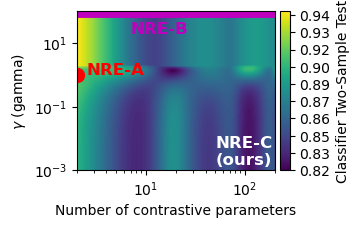

In [8]:
fig, ax = plt.subplots(figsize=figsize)
fontdict = {
    "fontsize": "large",
    "fontweight": "black",
}

# contour
CS = ax.contourf(
    xnew, 
    ynew, 
    znew,
    levels=100,
)

# NRE-A
ax.scatter(
    x=2,
    y=1,
    s=100,
    c="r",
)

ax.text(x=2 + .5, y=1, s="NRE-A", fontdict=merge({"color": "r"}, fontdict))

# NRE-B
ax.hlines(
    y=10 ** ymax - 0.5,
    xmin=xmin,
    xmax=xmax,
    colors="m",
    linewidth=10.0
)

ax.text(x=7, y=10 ** ymax - 80, s="NRE-B", fontdict=merge({"color": "m"}, fontdict))

# NRE-C
ax.text(x=50, y=0.005, s="NRE-C", fontdict=merge({"color": "w"}, fontdict))
ax.text(x=50, y=0.0015, s="(ours)", fontdict=merge({"color": "w"}, fontdict))

# labels
ax.set_ylabel(r"$\gamma$ (gamma)")
ax.set_yscale("log")
ax.set_xlabel("Number of contrastive parameters")
ax.set_xscale("log")


def myfmt(x, pos):
    return '{0:.2f}'.format(x)


# colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(CS, cax=cax, format=ticker.FuncFormatter(myfmt))
cbar.set_label('Classifier Two-Sample Test')

fig.savefig("conceptual.png", dpi=300, bbox_inches="tight")

## polynomial

In [9]:
df_many = df.reset_index()[columns + ["C2ST_Z"]]
df_many = select_architechture_and_algorithm(df_many)
X = df_many[["num_atoms", "gamma"]].to_numpy()
y = df_many["C2ST_Z"].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [10]:
poly = PolynomialFeatures(degree=4)
poly.fit_transform(X_train)

ridge = GridSearchCV(
    Ridge(alpha=1.0),
    param_grid={"alpha": [1e-2, 1e-1, 1e0, 1e1, 1e2]}
)
ridge.fit(X, y)

GridSearchCV(estimator=Ridge(),
             param_grid={'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]})

In [11]:
ridge.score(X_test, y_test)

0.09354633444405103

In [12]:
X, Y = np.meshgrid(xnew, ynew)
pts = np.stack([X, Y], axis=-1).reshape(-1, 2)
Z = ridge.predict(pts).reshape(N, N)

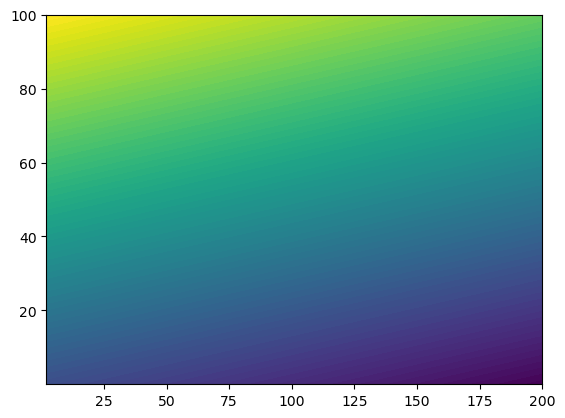

In [13]:
fig, ax = plt.subplots()
CS = ax.contourf(
    X, 
    Y, 
    Z,
    levels=100
)

In [14]:
raise NotImplementedError()

NotImplementedError: 

## validation lossreset_index

In [ ]:
root = Path("/home/ben/sci/cnre/infinite/")
experiment_folders = {
    "slcp": root / "outputs/2022-04-18/17-17-25",
    "two_moons": root / "outputs/2022-04-18/18-04-06",
    "gaussian_mixture": root / "outputs/2022-04-18/18-11-35",
    "gaussian_linear_uniform": root / "outputs/2022-04-18/18-24-56",
    # "slcp-big": root / "multirun/2022-04-19/10-20-49/2",
    # "two_moons-big": root / "multirun/2022-04-19/10-20-49/0",
    # "gaussian_mixture-big": root / "multirun/2022-04-19/10-20-49/1",
    # "gaussian_linear_uniform-big": root / "multirun/2022-04-19/10-20-49/3",
}
filename = "validation_loss.csv.bz2"

In [ ]:
fig, axes = plt.subplots(ncols=len(experiment_folders), sharey="row", figsize=(15,5))
for ax, (name, experiment_folder) in zip(axes.flatten(), experiment_folders.items()):
    validation_loss = get_tensor_from_csv(experiment_folder / filename)
    ax.semilogy(validation_loss)
    # ax.loglog(validation_loss)
    ax.set_title(name)

## metrics csv

`/home/ben/sci/cnre/infinite/multirun/2022-04-22/12-33-04` "big", CNRE `slcp` & `gaussian_mixture`, reuse=True  
`/home/ben/sci/cnre/infinite/multirun/2022-04-28/11-48-27` "big", CNRE `two_moons`, reuse=True  
`/home/ben/sci/cnre/infinite/multirun/2022-04-28/21-08-52` "big", NRE, `slcp` & `gaussian_mixture` & `two_moons`, reuse=True  


`/home/ben/sci/cnre/infinite/multirun/2022-04-29/*` two "big" runs, CNRE, `gaussian_mixture`, reuse=True  

`/home/ben/sci/cnre/infinite/multirun/2022-04-30/17-32-15/summarizemetrics.py` CNRE, `slcp`, `two_moons`, `gaussian_mixture`, reuse=False, 200 atoms  


This one is the first cheap prior runs:  
2022-05-02 both on das5 and nada

In [ ]:
files = [
    # "metrics-3layer-reuse-false.csv",
    # "metrics-2layer-reuse-false.csv", 
    "metrics-prior.csv", 
]
df = pd.concat([pd.read_csv(file, index_col=0) for file in files], ignore_index=True)
print(len(df))
print(df.columns)
print(df["algorithm"].unique())
df.head()

In [ ]:
# groupby drops NaNs fix this here.
df["gamma"] = df["gamma"].fillna(1.0)

df_wide = pd.wide_to_long(
    df, 
    ["C2ST_Z"], 
    i=["task", "algorithm", "num_atoms", "gamma", "num_blocks", "hidden_features", "seed"], 
    j="num_observation", 
    sep="-"
)

# groupby drops NaNs
grp = df_wide.groupby([
    "task",
    "algorithm",
    "num_atoms",
    "gamma",
    "num_blocks",
    "hidden_features",
])
grp.count()
# grp.aggregate({
#     "C2ST_Z": ["mean", "std"],
# })

In [ ]:
fg = sns.relplot(
    data=df_wide,
    x="num_atoms",
    y="C2ST_Z",
    hue="gamma",
    style="algorithm",
    col="task",
    row="num_blocks",
    kind="line",
    hue_norm=LogNorm(),
)
for ax in fg.axes.flatten():
    ax.set(xscale='log') 

In [ ]:
sns.relplot(
    data=df_wide,
    x="num_atoms",
    y="C2ST_Z",
    hue="gamma",
    style="algorithm",
    # col="task",
    row="num_blocks",
    kind="line",
    hue_norm=LogNorm(),
)